In [1]:
import os 
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np 

print(tf.__version__)


2.1.0


## TF2.Keras MNIST Model 

In [2]:
# Build Model 
mnist = tf.keras.Sequential([
  tf.keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])

# Export Servable 
export_mnist_path = './tmp/mnist/1/'

tf.keras.models.save_model(
    mnist,
    export_mnist_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

W0301 22:10:33.555729 4497593792 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


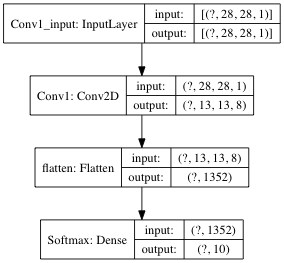

In [3]:
tf.keras.utils.plot_model(mnist, show_shapes=True, dpi=64)

In [4]:
# Prepare Data
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

test_images = test_images / 255.0
train_images = train_images / 255.0

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1) # [B, H, W, 1]

out = mnist(test_images[:1], training=False)
print('mnist output shape', out.shape)
print('mnist output type', type(out))
print('mnist output dtype', out.dtype)

# Input type can be either numpy array / tensor 
print('mnist input shape', test_images[:1].shape)
print('mnist inpur type', type(test_images[:1]))
print('mnist input dtype', test_images[:1].dtype)


W0301 22:10:38.470768 4497593792 base_layer.py:1790] Layer Conv1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



mnist output shape (1, 10)
mnist output type <class 'tensorflow.python.framework.ops.EagerTensor'>
mnist output dtype <dtype: 'float32'>
mnist input shape (1, 28, 28, 1)
mnist inpur type <class 'numpy.ndarray'>
mnist input dtype float64


In [5]:
# Start Docker & Servable 
# See README.md for more informaiton 

In [6]:
# Check saved model for basic info 
!saved_model_cli show --dir {export_mnist_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0301 22:11:14.525088 4686833088 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops

In [7]:
# Check ip:port connection 
!curl http://localhost:/8501/v1/models/mnist

curl: (56) Recv failure: Connection reset by peer


In [9]:
# Send request through REST 

import json
import random 
import requests

data = json.dumps({"signature_name": "serving_default", 
                   "instances": test_images[:1].tolist()})
headers = {"content-type": "application/json"}

# Without specify model version (use latest)
json_response = requests.post('http://localhost:8501/v1/models/mnist:predict', \
                              data=data, headers=headers)

json_response.text


NameError: name 'test_images' is not defined

In [10]:
# Send request through gRPC

# pip3 install tensorflow-serving-api

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
import grpc

def request_server(img, hostport):
    '''
    Input:
        img [1, H, W, 3] : input image
        hostport : tf server port 
    '''
    img = img.astype('float32')
    channel = grpc.insecure_channel(hostport)
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    request.model_spec.name = "mnist"
    request.model_spec.signature_name = "serving_default"  # From signature_def['serving_default']:
    request.inputs["Conv1_input"].CopyFrom( # From inputs['Conv1_input'] tensor_info:
        tf.make_tensor_proto(img, shape=list(img.shape)))  
    response = stub.Predict(request, 5.0)  # 5 secs timeout
    return response

response = request_server(test_images[:1], '0.0.0.0:8500')
print(response.outputs['Softmax']) # From outputs['Softmax'] tensor_info:


NameError: name 'test_images' is not defined

## TF2.Keras Generator Model 

1. [TF Server RESTful API document](https://www.tensorflow.org/tfx/serving/api_rest)

2. [TF Server REST API Example](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple)

In [20]:
# Build Model 
def downsample(filters, size, apply_batchnorm=True):
    '''
    Input Size: [B, H, W, C]
    '''
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    '''
    Input Size: [B, H, W, C]
    '''
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3]) # (None, 256, 256, 3)

    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()


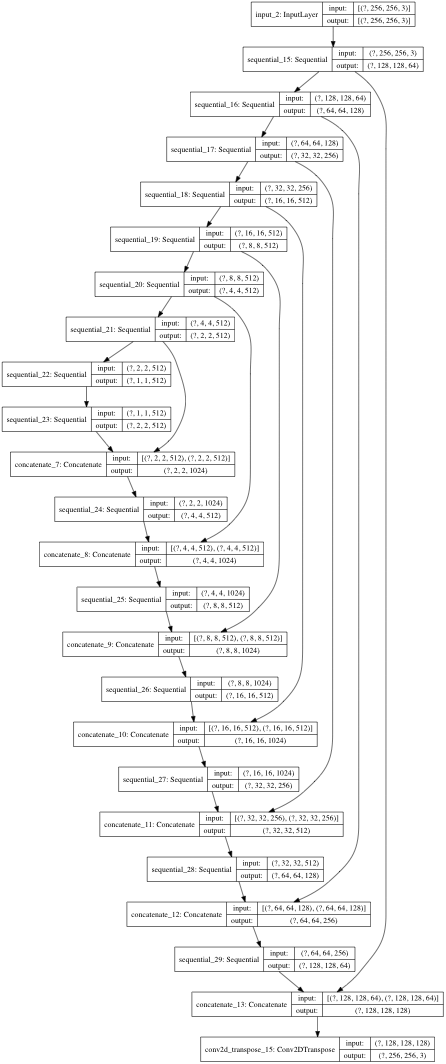

In [21]:
# Plot Graph 
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=40)

In [22]:
# Save Model 
export_generator_path = './tmp/generator/1/'

tf.keras.models.save_model(
    generator,
    export_generator_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

input images type <class 'tensorflow.python.framework.ops.EagerTensor'>
input images dtype <dtype: 'float32'>
input image shape (1, 256, 256, 3)
output images type <class 'tensorflow.python.framework.ops.EagerTensor'>
output images dtype <dtype: 'float32'>
output image shape (1, 256, 256, 3)


W0301 23:42:27.851516 4577109440 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


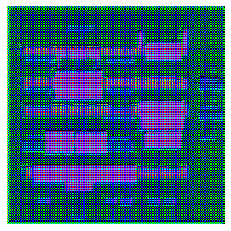

output image range max : 1.0000001192092896, min : -1.0000001192092896


In [23]:
# Prepare data 
def load_img(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

input_img, real_img = load_img('./facades/train/100.jpg')

# Input of the model can be either numpy array / tensor 
# input_img = input_img.numpy()

print('input images type', type(input_img))
print('input images dtype', input_img.dtype)
print('input image shape', input_img[tf.newaxis,...].shape)

output_img = generator(input_img[tf.newaxis,...], training=False)

print('output images type', type(output_img))
print('output images dtype', output_img.dtype)
print('output image shape', output_img.shape)

plt.figure()
plt.imshow(output_img[0])
plt.axis('off')
plt.show()

print('output image range max : {}, min : {}'.format(  np.max(output_img.numpy()), np.min(output_img.numpy())   ))



In [24]:
# Check saved model for basic info 
!saved_model_cli show --dir {export_generator_path} --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 256, 256, 3)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['conv2d_transpose_15'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 256, 256, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0301 23:42:46.371208 4606158272 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_

In [27]:
# Send request through REST 

import json
import random 
import requests

data = json.dumps({"signature_name": "serving_default", 
                   "instances": input_img[tf.newaxis,...].numpy().tolist()})
headers = {"content-type": "application/json"}

# Without specify model version (use latest)
json_response = requests.post('http://localhost:8501/v1/models/generator:predict', \
                              data=data, headers=headers)

json_response



<Response [200]>

W0302 00:03:41.561721 4577109440 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


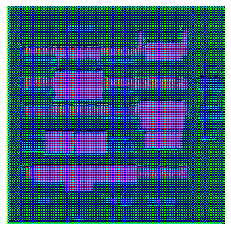

output image max : 1.00000012, min : -1.00000012


In [28]:
output_img = json.loads(json_response.text)['predictions']
output_img = np.asarray(output_img)

plt.figure()
plt.imshow(output_img[0])
plt.axis('off')
plt.show()

print('output image max : {}, min : {}'.format(np.max(output_img), np.min(output_img)))

In [29]:
# Send request through gRPC

def request_server(img, hostport):
    '''
    Input:
        img [1, H, W, 3] : input image
        hostport : tf server port 
    '''
    channel = grpc.insecure_channel(hostport)
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    request.model_spec.name = "generator"
    request.model_spec.signature_name = "serving_default"  
    request.inputs["input_2"].CopyFrom(
        tf.make_tensor_proto(img, shape=list(img.shape)))  
    response = stub.Predict(request, 5.0)  # 5 secs timeout
    return response

response = request_server(input_img[tf.newaxis,...], '0.0.0.0:8500')
output_img = response.outputs['conv2d_transpose_15']
output_img = tf.make_ndarray(output_img)


_Rendezvous: <_Rendezvous of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "Socket closed"
	debug_error_string = "{"created":"@1583136867.999103000","description":"Error received from peer ipv4:0.0.0.0:8500","file":"src/core/lib/surface/call.cc","file_line":1055,"grpc_message":"Socket closed","grpc_status":14}"
>

W0301 23:43:16.348129 4577109440 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


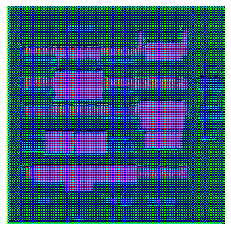

output image max : 1.0000001192092896, min : -1.0000001192092896


In [26]:
plt.figure()
plt.imshow(output_img[0])
plt.axis('off')
plt.show()

print('output image max : {}, min : {}'.format(np.max(output_img), np.min(output_img)))

## TF1.x Session MNIST Servable

In [ ]:
tensor_info_x = tf.compat.v1.saved_model.utils.build_tensor_info(x) # define input output information 
tensor_info_y = tf.compat.v1.saved_model.utils.build_tensor_info(y)

prediction_signature = (  # required argument 
    tf.compat.v1.saved_model.signature_def_utils.build_signature_def(
          inputs={'images': tensor_info_x},
          outputs={'scores': tensor_info_y},
          method_name=tf.compat.v1.saved_model.signature_constants.PREDICT_METHOD_NAME)
          )

builder.add_meta_graph_and_variables( 
    sess, [tf.compat.v1.saved_model.tag_constants.SERVING],
    signature_def_map={
          'predict_images': prediction_signature,
          tf.compat.v1.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:classification_signature,  # optional argument 
      },
    main_op=tf.compat.v1.tables_initializer(),  # optional argument 
    strip_default_attrs=True)  # optional argument 

builder.save()
    
    